**Ensemble Model-1 (Resnet50 + MobileNetV2 + Xception)**

Loading Dataset

In [ ]:
from tensorflow.keras.models import load_model
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import joblib

In [ ]:
import os
import numpy as np
from sklearn.model_selection import train_test_split

# Directory where arrays are saved
directory = '/content/drive/MyDrive/arrays27'

# File paths
x_train_path = os.path.join(directory, 'x_train.npy')
x_test_path = os.path.join(directory, 'x_test.npy')
x_val_path = os.path.join(directory, 'x_val.npy')
y_train_path = os.path.join(directory, 'y_train.npy')
y_test_path = os.path.join(directory, 'y_test.npy')
y_val_path = os.path.join(directory, 'y_val.npy')

# Load arrays
x_train = np.load(x_train_path)
x_test = np.load(x_test_path)
x_val = np.load(x_val_path)
y_train = np.load(y_train_path)
y_test = np.load(y_test_path)
y_val = np.load(y_val_path)

print(f"Loaded data from {directory}")
print(x_train.shape, x_test.shape, x_val.shape, y_train.shape, y_test.shape, y_val.shape)

Loaded data from /content/drive/MyDrive/arrays27
(3751, 299, 299, 3) (1042, 299, 299, 3) (417, 299, 299, 3) (3751,) (1042,) (417,)


**Loading base Models**

In [ ]:
# Load the pre-trained models
mobilenet = load_model('/content/drive/MyDrive/Models/MobileNetV2_28.hdf5')
resnet50 = load_model('/content/drive/MyDrive/Models/Resnet50.hdf5')
inceptionv3 = load_model('/content/drive/MyDrive/Models/Xception.hdf5')

In [ ]:
def get_model_predictions(model, data):
    return model.predict(data)

# Generate predictions for the train set
mobilenet_train_preds = get_model_predictions(mobilenet, x_train)
resnet50_train_preds = get_model_predictions(resnet50, x_train)
inceptionv3_train_preds = get_model_predictions(inceptionv3, x_train)

# Generate predictions for the validation set
mobilenet_val_preds = get_model_predictions(mobilenet, x_val)
resnet50_val_preds = get_model_predictions(resnet50, x_val)
inceptionv3_val_preds = get_model_predictions(inceptionv3, x_val)


14/14 [==============================] - 4s 267ms/step


In [ ]:
# Combine the train and validation predictions
combined_train_preds = np.concatenate(
    [mobilenet_train_preds, resnet50_train_preds, inceptionv3_train_preds],
    axis=1
)

combined_val_preds = np.concatenate(
    [mobilenet_val_preds, resnet50_val_preds, inceptionv3_val_preds],
    axis=1
)

In [ ]:
# # Train labels (assuming y_train and y_val are already in the correct shape)
# train_labels = np.argmax(y_train, axis=1)
# val_labels = np.argmax(y_val, axis=1)



Training the meta classifier (stacking ensemble model)

In [ ]:
# Initialize and train the meta-classifier
meta_classifier = LogisticRegression(max_iter=1000)
meta_classifier.fit(combined_train_preds, y_train)

# Generate predictions with the meta-classifier on the validation set
meta_val_predictions = meta_classifier.predict(combined_val_preds)


In [ ]:
from sklearn.metrics import log_loss, accuracy_score

# Evaluate the meta-classifier on the validation set
val_preds = meta_classifier.predict_proba(combined_val_preds)
val_loss = log_loss(y_val, val_preds)
val_accuracy = accuracy_score(y_val, meta_val_predictions)

print(f"Validation Loss: {val_loss:.4f}")
print(f"Validation Accuracy: {val_accuracy:.4f}")


Validation Loss: 0.0815
Validation Accuracy: 0.9760


In [ ]:
# Evaluate the meta-classifier on the validation set
print(classification_report(y_val, meta_val_predictions, target_names=['Normal', 'Covid_positive', 'Lung_Opacity', 'Viral_Pneumonia']))

# Generate the confusion matrix
cm = confusion_matrix(y_val, meta_val_predictions)
print("Confusion Matrix:\n", cm)

# Save the meta-classifier
meta_model_path = '/content/drive/MyDrive/Models/meta_classifier.pkl'
joblib.dump(meta_classifier, meta_model_path)
print(f"Meta-model saved to {meta_model_path}")


                 precision    recall  f1-score   support

         Normal       0.99      0.95      0.97       103
 Covid_positive       0.97      0.98      0.98       105
   Lung_Opacity       0.96      0.98      0.97       115
Viral_Pneumonia       0.99      0.99      0.99        94

       accuracy                           0.98       417
      macro avg       0.98      0.98      0.98       417
   weighted avg       0.98      0.98      0.98       417

Confusion Matrix:
 [[ 98   1   4   0]
 [  0 103   1   1]
 [  0   2 113   0]
 [  1   0   0  93]]
Meta-model saved to /content/drive/MyDrive/Models/meta_classifier.pkl


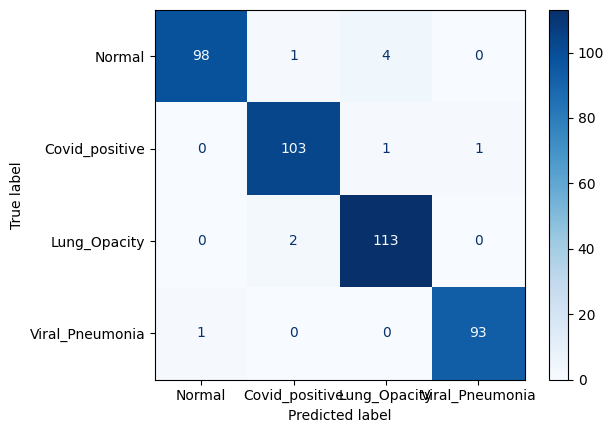

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay  # Import ConfusionMatrixDisplay

# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Normal', 'Covid_positive', 'Lung_Opacity', 'Viral_Pneumonia'])
disp.plot(cmap=plt.cm.Blues)
plt.show()

In [ ]:
# Now for testing on the test set
mobilenet_test_preds = get_model_predictions(mobilenet, x_test)
resnet50_test_preds = get_model_predictions(resnet50, x_test)
inceptionv3_test_preds = get_model_predictions(inceptionv3, x_test)

combined_test_preds = np.concatenate(
    [mobilenet_test_preds, resnet50_test_preds, inceptionv3_test_preds],
    axis=1
)

# Test labels
# test_labels = np.argmax(y_test, axis=1)

# Generate predictions with the meta-classifier on the test set
meta_test_predictions = meta_classifier.predict(combined_test_preds)

# Evaluate the meta-classifier on the test set
print(classification_report(y_test, meta_test_predictions, target_names=['Normal', 'Covid_positive', 'Lung_Opacity', 'Viral_Pneumonia']))

# Generate the confusion matrix for the test set
cm_test = confusion_matrix(y_test, meta_test_predictions)
print("Confusion Matrix:\n", cm_test)

33/33 [==============================] - 7s 214ms/step
                 precision    recall  f1-score   support

         Normal       0.96      0.95      0.96       274
 Covid_positive       0.98      0.96      0.97       249
   Lung_Opacity       0.94      0.98      0.96       256
Viral_Pneumonia       0.98      0.97      0.98       263

       accuracy                           0.97      1042
      macro avg       0.97      0.97      0.97      1042
   weighted avg       0.97      0.97      0.97      1042

Confusion Matrix:
 [[261   1   8   4]
 [  3 238   7   1]
 [  3   1 252   0]
 [  5   2   0 256]]


In [ ]:
# Generate predictions with the meta-classifier on the test set
test_preds = meta_classifier.predict_proba(combined_test_preds)
test_loss = log_loss(y_test, test_preds)
test_accuracy = accuracy_score(y_test, meta_test_predictions)

print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")


Test Loss: 0.0994
Test Accuracy: 0.9664


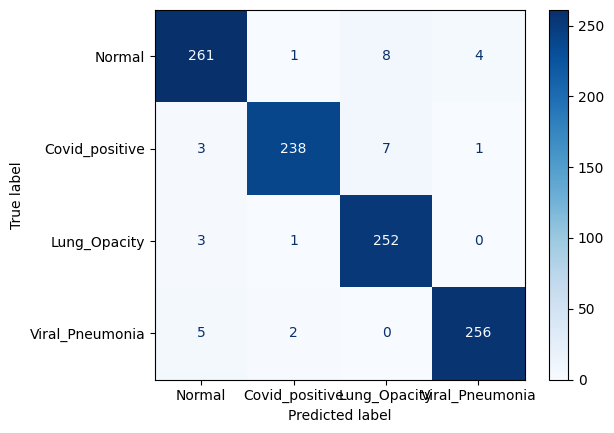

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay  # Import ConfusionMatrixDisplay

# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm_test, display_labels=['Normal', 'Covid_positive', 'Lung_Opacity', 'Viral_Pneumonia'])
disp.plot(cmap=plt.cm.Blues)
plt.show()

HyperParameter Tuning for meta model using GridSearch Optimization

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

# Define the parameter grid
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'max_iter': [200, 500, 1000]
}

# Initialize the logistic regression model
meta_classifier = LogisticRegression()

# Initialize GridSearchCV
grid_search = GridSearchCV(meta_classifier, param_grid, cv=5, scoring='accuracy')

# Fit GridSearchCV on the combined training predictions
grid_search.fit(combined_train_preds, y_train)

# Best hyperparameters
print(f"Best Hyperparameters: {grid_search.best_params_}")

# Use the best model for predictions
best_meta_classifier = grid_search.best_estimator_

# Evaluate on the validation set
meta_val_predictions = best_meta_classifier.predict(combined_val_preds)
print(classification_report(y_val, meta_val_predictions, target_names=['Normal', 'Covid_positive', 'Lung_Opacity', 'Viral_Pneumonia']))

val_accuracy = accuracy_score(y_val, meta_val_predictions)
val_loss = log_loss(y_val, best_meta_classifier.predict_proba(combined_val_preds))
print(f"Validation Accuracy: {val_accuracy}")
print(f"Validation Log Loss: {val_loss}")

# Save the best meta-classifier
meta_model_path = '/content/drive/MyDrive/Models/hyperparameter_meta_classifier.pkl'
joblib.dump(best_meta_classifier, meta_model_path)
print(f"Meta-model saved to {meta_model_path}")

# Evaluate on the test set
meta_test_predictions = best_meta_classifier.predict(combined_test_preds)
print(classification_report(y_test, meta_test_predictions, target_names=['Normal', 'Covid_positive', 'Lung_Opacity', 'Viral_Pneumonia']))

test_accuracy = accuracy_score(y_test, meta_test_predictions)
test_loss = log_loss(y_test, best_meta_classifier.predict_proba(combined_test_preds))
print(f"Test Accuracy: {test_accuracy}")
print(f"Test Log Loss: {test_loss}")

# Generate the confusion matrix for the test set
cm_test = confusion_matrix(y_test, meta_test_predictions)
print("Confusion Matrix:\n", cm_test)


Best Hyperparameters: {'C': 0.01, 'max_iter': 200}
                 precision    recall  f1-score   support

         Normal       0.99      0.95      0.97       103
 Covid_positive       0.97      0.98      0.98       105
   Lung_Opacity       0.96      0.98      0.97       115
Viral_Pneumonia       0.99      0.99      0.99        94

       accuracy                           0.98       417
      macro avg       0.98      0.98      0.98       417
   weighted avg       0.98      0.98      0.98       417

Validation Accuracy: 0.9760191846522782
Validation Log Loss: 0.16347154186864118
Meta-model saved to /content/drive/MyDrive/Models/hyperparameter_meta_classifier.pkl
                 precision    recall  f1-score   support

         Normal       0.96      0.96      0.96       274
 Covid_positive       0.98      0.96      0.97       249
   Lung_Opacity       0.95      0.98      0.97       256
Viral_Pneumonia       0.98      0.97      0.98       263

       accuracy                      

In [ ]:
# Generate predictions with the meta-classifier on the test set
test_preds = best_meta_classifier.predict_proba(combined_test_preds)
test_loss = log_loss(y_test, test_preds)
test_accuracy = accuracy_score(y_test, meta_test_predictions)

print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")


Test Loss: 0.1838
Test Accuracy: 0.9683


Trying different meta models under stacking ensemble
NeuralNetwork meta model

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

# Define the neural network meta-model
meta_model = Sequential()
meta_model.add(Dense(128, activation='relu', input_dim=combined_train_preds.shape[1]))
meta_model.add(Dense(64, activation='relu'))
meta_model.add(Dense(4, activation='softmax'))  # Adjust the number of classes as needed

# Compile the meta-model
meta_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the meta-model
meta_model.fit(combined_train_preds, y_train, epochs=20, validation_data=(combined_val_preds, y_val), batch_size=32)

# Evaluate the meta-model on the validation set
val_loss, val_accuracy = meta_model.evaluate(combined_val_preds, y_val)
print(f"Validation Accuracy: {val_accuracy}")
print(f"Validation Loss: {val_loss}")

# Save the neural network meta-model
meta_model.save('/content/drive/MyDrive/Models/neural_meta_model.hd5')
print("Neural network meta-model saved.")

# Evaluate on the test set
test_loss, test_accuracy = meta_model.evaluate(combined_test_preds, y_test)
print(f"Test Accuracy: {test_accuracy}")
print(f"Test Loss: {test_loss}")

# Generate predictions for the test set and classification report
meta_test_predictions = np.argmax(meta_model.predict(combined_test_preds), axis=1)
print(classification_report(y_test, meta_test_predictions, target_names=['Normal', 'Covid_positive', 'Lung_Opacity', 'Viral_Pneumonia']))

# Generate the confusion matrix for the test set
cm_test = confusion_matrix(y_test, meta_test_predictions)
print("Confusion Matrix:\n", cm_test)


Epoch 1/20
118/118 [==============================] - 3s 5ms/step - loss: 0.2757 - accuracy: 0.9736 - val_loss: 0.0835 - val_accuracy: 0.9784
Epoch 2/20
118/118 [==============================] - 0s 3ms/step - loss: 0.0026 - accuracy: 1.0000 - val_loss: 0.0926 - val_accuracy: 0.9760
Epoch 3/20
118/118 [==============================] - 0s 3ms/step - loss: 6.6150e-04 - accuracy: 1.0000 - val_loss: 0.1007 - val_accuracy: 0.9760
Epoch 4/20
118/118 [==============================] - 0s 3ms/step - loss: 3.0519e-04 - accuracy: 1.0000 - val_loss: 0.1068 - val_accuracy: 0.9760
Epoch 5/20
118/118 [==============================] - 0s 3ms/step - loss: 1.7338e-04 - accuracy: 1.0000 - val_loss: 0.1108 - val_accuracy: 0.9736
Epoch 6/20
118/118 [==============================] - 0s 3ms/step - loss: 1.1186e-04 - accuracy: 1.0000 - val_loss: 0.1150 - val_accuracy: 0.9736
Epoch 7/20
118/118 [==============================] - 0s 3ms/step - loss: 7.7557e-05 - accuracy: 1.0000 - val_loss: 0.1182 - val_acc

In [ ]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, BatchNormalization, Dense, Input, Concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import joblib

# Function to extract intermediate features
def extract_intermediate_features(model, data):
    intermediate_layer_model = Model(inputs=model.input, outputs=model.layers[-3].output)
    intermediate_features = intermediate_layer_model.predict(data)
    return intermediate_features

# Extract intermediate features for train, validation, and test sets
mobilenet_train_intermediate = extract_intermediate_features(mobilenet, x_train)
resnet50_train_intermediate = extract_intermediate_features(resnet50, x_train)
inceptionv3_train_intermediate = extract_intermediate_features(inceptionv3, x_train)

mobilenet_val_intermediate = extract_intermediate_features(mobilenet, x_val)
resnet50_val_intermediate = extract_intermediate_features(resnet50, x_val)
inceptionv3_val_intermediate = extract_intermediate_features(inceptionv3, x_val)

mobilenet_test_intermediate = extract_intermediate_features(mobilenet, x_test)
resnet50_test_intermediate = extract_intermediate_features(resnet50, x_test)
inceptionv3_test_intermediate = extract_intermediate_features(inceptionv3, x_test)

# Generate predictions for train, validation, and test sets
mobilenet_train_preds = mobilenet.predict(x_train)
resnet50_train_preds = resnet50.predict(x_train)
inceptionv3_train_preds = inceptionv3.predict(x_train)

mobilenet_val_preds = mobilenet.predict(x_val)
resnet50_val_preds = resnet50.predict(x_val)
inceptionv3_val_preds = inceptionv3.predict(x_val)

mobilenet_test_preds = mobilenet.predict(x_test)
resnet50_test_preds = resnet50.predict(x_test)
inceptionv3_test_preds = inceptionv3.predict(x_test)

# Combine features and predictions
combined_train_features = np.concatenate(
    [mobilenet_train_intermediate, resnet50_train_intermediate, inceptionv3_train_intermediate,
     mobilenet_train_preds, resnet50_train_preds, inceptionv3_train_preds],
    axis=1
)

combined_val_features = np.concatenate(
    [mobilenet_val_intermediate, resnet50_val_intermediate, inceptionv3_val_intermediate,
     mobilenet_val_preds, resnet50_val_preds, inceptionv3_val_preds],
    axis=1
)

combined_test_features = np.concatenate(
    [mobilenet_test_intermediate, resnet50_test_intermediate, inceptionv3_test_intermediate,
     mobilenet_test_preds, resnet50_test_preds, inceptionv3_test_preds],
    axis=1
)

# Labels
train_labels = y_train
val_labels = y_val
test_labels = y_test

# Define a more complex meta-model
input_layer = Input(shape=(combined_train_features.shape[1],))
x = Dense(512, activation='relu')(input_layer)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(64, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
output_layer = Dense(4, activation='softmax')(x)

meta_model = Model(inputs=input_layer, outputs=output_layer)
meta_model.compile(optimizer=Adam(learning_rate=3e-4), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the meta-model
history = meta_model.fit(
    combined_train_features, train_labels,
    epochs=100,
    batch_size=32,
    validation_data=(combined_val_features, val_labels),
    callbacks=[EarlyStopping(patience=10, restore_best_weights=True)]
)

# Evaluate on validation set
val_loss, val_accuracy = meta_model.evaluate(combined_val_features, val_labels)
print(f"Validation Accuracy: {val_accuracy}")
print(f"Validation Loss: {val_loss}")

# Save the meta-model
meta_model.save('path_to_save_meta_model/complex_Neural_meta_model.h5')
print("Meta-model saved.")

# Evaluate on test set
test_loss, test_accuracy = meta_model.evaluate(combined_test_features, test_labels)
print(f"Test Accuracy: {test_accuracy}")
print(f"Test Loss: {test_loss}")

# Generate predictions for the test set and classification report
meta_test_predictions = np.argmax(meta_model.predict(combined_test_features), axis=1)
print(classification_report(test_labels, meta_test_predictions, target_names=['Normal', 'Covid_positive', 'Lung_Opacity', 'Viral_Pneumonia']))

# Generate the confusion matrix for the test set
cm_test = confusion_matrix(test_labels, meta_test_predictions)
print("Confusion Matrix:\n", cm_test)


33/33 [==============================] - 7s 225ms/step
Epoch 1/100
118/118 [==============================] - 7s 10ms/step - loss: 0.7011 - accuracy: 0.7499 - val_loss: 0.1197 - val_accuracy: 0.9736
Epoch 2/100
118/118 [==============================] - 1s 7ms/step - loss: 0.1879 - accuracy: 0.9456 - val_loss: 0.1040 - val_accuracy: 0.9712
Epoch 3/100
118/118 [==============================] - 1s 10ms/step - loss: 0.1061 - accuracy: 0.9765 - val_loss: 0.0997 - val_accuracy: 0.9712
Epoch 4/100
118/118 [==============================] - 1s 10ms/step - loss: 0.0870 - accuracy: 0.9760 - val_loss: 0.1042 - val_accuracy: 0.9712
Epoch 5/100
118/118 [==============================] - 1s 10ms/step - loss: 0.0644 - accuracy: 0.9856 - val_loss: 0.1199 - val_accuracy: 0.9712
Epoch 6/100
118/118 [==============================] - 1s 7ms/step - loss: 0.0532 - accuracy: 0.9893 - val_loss: 0.1237 - val_accuracy: 0.9712
Epoch 7/100
118/118 [==============================] - 1s 8ms/step - loss: 0.0359 -

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


33/33 [==============================] - 0s 4ms/step - loss: 0.1077 - accuracy: 0.9683
Test Accuracy: 0.9683301448822021
Test Loss: 0.10773421078920364
33/33 [==============================] - 0s 3ms/step
                 precision    recall  f1-score   support

         Normal       0.96      0.96      0.96       274
 Covid_positive       0.97      0.97      0.97       249
   Lung_Opacity       0.95      0.98      0.96       256
Viral_Pneumonia       0.99      0.97      0.98       263

       accuracy                           0.97      1042
      macro avg       0.97      0.97      0.97      1042
   weighted avg       0.97      0.97      0.97      1042

Confusion Matrix:
 [[263   1   8   2]
 [  2 241   5   1]
 [  2   4 250   0]
 [  6   2   0 255]]


In [ ]:
meta_model.save('/content/drive/MyDrive/Models/complex_Neural_meta_model.hd5')
print("Meta-model saved.")

Meta-model saved.
